In [6]:
import uproot, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [25]:
## Read Electron Total Energy Nonlinearity:
Etrue = np.arange(0.01, 8, 0.01);
df = pd.read_table('../../../Simulation/Nonlinearity/electron/MC_NonL.txt');
electron_NL = df['nonl'].values

In [26]:
## Read Electron Total Resolution
df = pd.read_table("../../../Simulation/Nonlinearity/electron/Cerenkov/totPE_smearing.txt", sep=' ')
electron_totpe = df['totpe'].values
electron_sigma = df['sigma'].values

In [27]:
## choose energy scale: 
A = 1481.06

In [28]:
## read primary e+- info for gamma  ===> binning in 10keV
bincont1 = [[]for i in range(800)]
with open('../../../Reconstruction/energy_model/gamma/log_511keV') as f:
    for lines in f.readlines():
        line = lines.strip(' \n')
        data = line.split(' ')
        KE = [];
        for i in range(len(data)):
            KE.append(float(data[i]))
        cont, edge = np.histogram(KE, bins=800, range=(0,8))
        for j in range(800):
            bincont1[j].append(cont[j])
bincon1 = np.array(bincont1)

In [29]:
### find the corresponding bin for energy:
def find_bin_Idx(xx, Etrue):
    if(xx<=Etrue[0]):   # in the first bin
        return int(0)
    for i in range(798):
        if(xx > Etrue[i] and xx <= Etrue[i+1] ):
            return int(i+1)
        
# interpolation:
def itpl(idx, array, xx):
    if(idx == 0):
        return array[0] / 0.01 * xx;
    else:
        return (array[idx]-array[idx-1])* (xx-0.01*(idx))/0.01 + array[idx-1]

In [8]:
# for single event
mean_dist = []; sigma_dist =[]; Evis_dist = []; Edep_dist = [];
for i in range(20):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.; Edep_evt = 0.;
    for j in range(799):
        #mean_evt += electron_totpe[i]*bincon1[j,i]
        Edep_evt += Etrue[j] *bincon1[j,i];
        Evis_evt += Etrue[j] *electron_NL[j] * bincon1[j,i];
        mean_evt += Etrue[j] *electron_NL[j] * bincon1[j,i] * A
        sigma_evt += bincon1[j,i]**2 * electron_sigma[j]**2
    sigma_evt = np.sqrt(sigma_evt)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt); Evis_dist.append(Evis_evt); Edep_dist.append(Edep_evt)
    print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))

Event0 =====> Average: 905.62 =====> Sigma: 61.69
Event1 =====> Average: 755.73 =====> Sigma: 33.25
Event2 =====> Average: 806.18 =====> Sigma: 53.59
Event3 =====> Average: 799.87 =====> Sigma: 46.05
Event4 =====> Average: 818.64 =====> Sigma: 49.72
Event5 =====> Average: 842.73 =====> Sigma: 58.65
Event6 =====> Average: 761.33 =====> Sigma: 36.87
Event7 =====> Average: 899.13 =====> Sigma: 68.45
Event8 =====> Average: 779.0 =====> Sigma: 29.85
Event9 =====> Average: 787.61 =====> Sigma: 35.28
Event10 =====> Average: 854.4 =====> Sigma: 54.13
Event11 =====> Average: 775.05 =====> Sigma: 33.53
Event12 =====> Average: 887.01 =====> Sigma: 61.66
Event13 =====> Average: 881.87 =====> Sigma: 57.99
Event14 =====> Average: 787.82 =====> Sigma: 37.61
Event15 =====> Average: 743.66 =====> Sigma: 30.86
Event16 =====> Average: 820.0 =====> Sigma: 47.29
Event17 =====> Average: 822.61 =====> Sigma: 44.29
Event18 =====> Average: 853.7 =====> Sigma: 52.56
Event19 =====> Average: 810.59 =====> Sigma: 

In [132]:
np.array(Evis_dist) / np.array(Edep_dist)

array([0.91618735, 0.9441501 , 0.91447503, 0.93835824, 0.90943252,
       0.89592013, 0.92557211, 0.89792119, 0.92371325, 0.90713159,
       0.90103288, 0.91203845, 0.91392779, 0.89616165, 0.90509722,
       0.89225935, 0.92521081, 0.87092156, 0.92417939, 0.92545713])

In [16]:
def gauss_dist(x, A, mean, sigma):
    return A*np.exp(-(x-mean)**2/2/sigma**2)

Text(0.5, 0, 'totalPE')

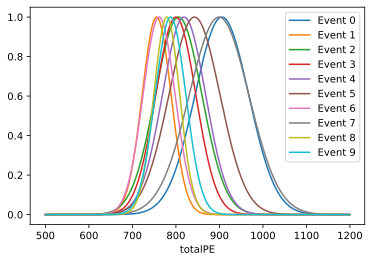

In [14]:
xx = np.arange(500,1200,1)
for j in range(10):
    for i in range(len(xx)):
        yy = gauss_dist(xx, mean_dist[j], sigma_dist[j])
    plt.plot(xx, yy, '-', label='Event %d' %j)
plt.legend()
plt.xlabel("totalPE")

In [201]:
gamma_totpe = 0.; gamma_sigma = 0.; gamma_Evis = 0.; count = 0;

In [8]:
## Predict with 1000 events with binning data
mean_dist = []; sigma_dist =[];
iterator = 5000;
for i in range(iterator):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.
    for j in range(799):
        count += bincon1[j,i]
        #mean_evt += electron_totpe[i]*bincon1[j,i]
        
        Evis_evt += Etrue[j] *electron_NL[j] * bincon1[j,i]
        mean_evt += Etrue[j] *electron_NL[j] * bincon1[j,i] * A
        sigma_evt += bincon1[j,i]**2 * electron_sigma[j]**2
        
        gamma_Evis += Etrue[j] *electron_NL[j] * bincon1[j,i]
        gamma_totpe += Etrue[j] *electron_NL[j] * bincon1[j,i]*A
        gamma_sigma += bincon1[j,i]/100 * electron_sigma[j]**2
     
        
    sigma_evt = np.sqrt(sigma_evt)
    gamma_totpe /= iterator; gamma_Evis /= iterator;
    gamma_sigma = np.sqrt(gamma_sigma)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt)
print(count)
    #print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))
print("1MeV gamma: Evis " + str(gamma_Evis) + " ===> totalPE " + str(gamma_totpe) + " ===> sigma " + str(gamma_sigma))

NameError: name 'count' is not defined

In [436]:
calc_resol_gamma3 = [];

In [30]:
### read primary e+- info for gamma  ===> no-binning
bincont2 = [[] for i in range(5000)]
evtId = 0
with open('../../../Reconstruction/energy_model/gamma/log_511keV') as f:
    for lines in f.readlines():
        line = lines.strip(' \n')
        data = line.split(' ')
        if(evtId < 5000):
            for i in range(len(data)):
                bincont2[evtId].append(float(data[i]))
            evtId+=1

In [31]:
## Predict with unbinning data
mean_dist = []; sigma_dist = []; Evis_dist = [];
iterator = 5000;   # evt number

for i in range(iterator):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.
    for j in range(len(bincont2[i])):
        bin_idx = find_bin_Idx(bincont2[i][j], Etrue)
        Evis_evt += bincont2[i][j] * electron_NL[bin_idx] #itpl(bin_idx, electron_NL, bincont2[i][j]) 
        mean_evt += bincont2[i][j] * electron_NL[bin_idx] * A #itpl(bin_idx, electron_NL, bincont2[i][j]) * A
        sigma_evt += itpl(bin_idx, electron_sigma, bincont2[i][j])**2
        
    sigma_evt = np.sqrt(sigma_evt)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt); Evis_dist.append(Evis_evt)
    #print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))



In [34]:
## sampling from 100 distributions:
import random
totalPE_1MeV_gamma = [];
for ii in range(100000):
    idx = int(random.uniform(0,5000))
    totalPE_1MeV_gamma.append(random.normalvariate(mean_dist[idx], sigma_dist[idx]))
totalPE_1MeV_gamma = np.array(totalPE_1MeV_gamma)
cont, bins = np.histogram(totalPE_1MeV_gamma, bins=100)
bins_center = [];
for i in range(len(bins)-1):
    bins_center.append((bins[i]+bins[i+1])/2.)

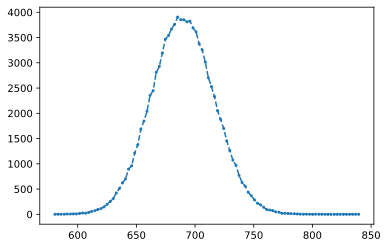

In [35]:
plt.plot(bins_center, cont, 'o--', ms=2)

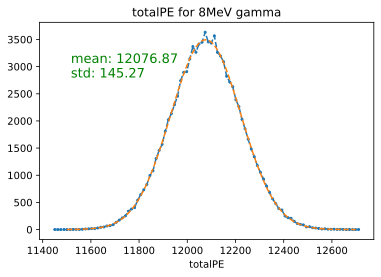

In [68]:
from scipy import optimize
popt, pcov = optimize.curve_fit(gauss_dist, bins_center, cont, [3500, 12000, 80])

plt.plot(bins_center, cont, 'o--', ms=2)
xx = np.arange(11500,12700,1)
yy = gauss_dist(xx, popt[0], popt[1], popt[2])
plt.plot(xx, yy, '--')
plt.xlabel("totalPE"); plt.title("totalPE for 8MeV gamma")
plt.text(11500,2800," mean: %.2f \n std: %.2f" %(popt[1], popt[2]), fontsize=13, color='green')

plt.savefig("8MeV_gamma_totalPE.svg")

In [10]:
## 511keV gamma prediction resolution:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.038761487625627936

In [456]:
calc_resol_gamma.append( np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean() )

Text(0.5, 1.0, 'sampling 511keV gamma totalPE with e- NonL&Resol')

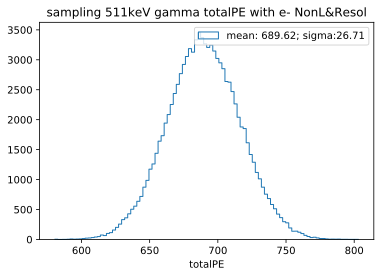

In [22]:
totalPE_1MeV_gamma = np.array(totalPE_1MeV_gamma)
plt.hist(totalPE_1MeV_gamma, histtype='step', bins=100, 
         label="mean: %.2f; sigma:%.2f" %(totalPE_1MeV_gamma.mean(), np.std(totalPE_1MeV_gamma)));
plt.legend()
plt.xlabel('totalPE')
plt.title('sampling 511keV gamma totalPE with e- NonL&Resol')
#plt.text(1300, 2600, "resolution: %.2f%%" %(np.std(totalPE_1MeV_gamma)/totalPE_1MeV_gamma.mean()*100), fontsize=14, color='green')

In [241]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.03944391795373381

In [247]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.02231931053606704

In [251]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.012814383347594027

In [255]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.009014203674450837

In [190]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.012143506454886564

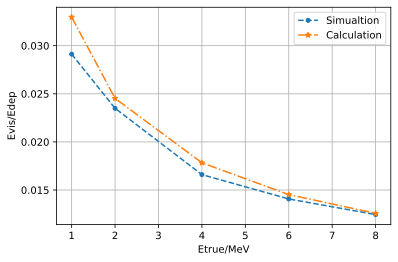

In [357]:
plt.plot([1,2,4,6,8], [0.02912, 0.02349, 0.01660, 0.01407, 0.01245], 'o--', ms=4, label='Simualtion')
#plt.plot([1,2,4,6,8], [0.04362, 0.02748, 0.01822, 0.01420, 0.01214], '*-.', ms=6, label='Calculation')
plt.plot([1,2,4,6,8], calc_resol_gamma, '*-.', ms=6, label='Calculation')

plt.xlabel("Etrue/MeV"); plt.ylabel("Evis/Edep")
plt.grid(True); plt.legend()

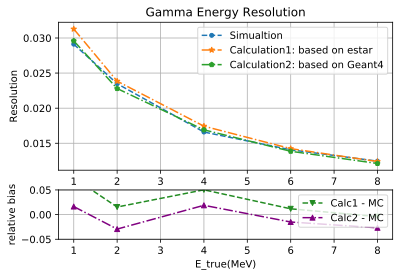

In [461]:

from pylab import *
from matplotlib import gridspec 
gs = gridspec.GridSpec(2,1,height_ratios=[3,1]) 

simul_resol_gamma = [0.02912, 0.02349, 0.01660, 0.01407, 0.01245];

ax0 = plt.subplot(gs[0])
plt.plot([1,2,4,6,8], [0.02912, 0.02349, 0.01660, 0.01407, 0.01245], 'o--', ms=4, label='Simualtion')
plt.plot([1,2,4,6,8], calc_resol_gamma3, '*-.', ms=6, label='Calculation1: based on estar')
plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')
#plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')


ax0.legend()
plt.grid(True)
plt.ylabel('Resolution')
plt.title('Gamma Energy Resolution')

ax1 = plt.subplot(gs[1])
ax1.plot([1,2,4,6,8], (np.array(calc_resol_gamma3)-np.array(simul_resol_gamma))/np.array(simul_resol_gamma), 
         'v--', ms=5,color='forestgreen', label="Calc1 - MC")
ax1.plot([1,2,4,6,8], (np.array(calc_resol_gamma2)-np.array(simul_resol_gamma))/np.array(simul_resol_gamma),
         '^-.', ms=5,color='purple', label="Calc2 - MC")
plt.grid(True)
#plt.yticks(np.arange(0, 1200, step=400))
plt.xlabel('E_true(MeV)')
plt.ylabel('relative bias')
plt.ylim(-0.05, 0.05)
plt.legend(loc='upper right')

#plt.savefig('compare_totalPE_electron.svg')

## Prediction of positron resolution

In [36]:
positron_resolution = [];
gamma_resol = 0.03872534870421328;
T_positron = [0.5, 1, 2, 4, 6, 8];
E_positron = [];
for i in T_positron:
    E_positron.append(i+2*0.511)
electron_bin = [49, 99, 199, 399, 599, 798];
totpe_positron_pred = []; totpe_sigma_positron_pred = [];

In [37]:
for i in range(len(T_positron)):
    
    # electron totalpe distribution
    mean1 = T_positron[i]*A*electron_NL[int(electron_bin[i])]; 
    std1 = electron_sigma[int(electron_bin[i])]; 
    
    # 0.511MeV gamma totalpe distribution
    mean2 = totalPE_1MeV_gamma.mean();
    std2 = np.std(totalPE_1MeV_gamma);
    
    ### sum of three distributions
    mean3 = mean1+2*mean2;
    std3 = np.sqrt(std1**2+std2**2+std2**2);
    totpe_positron_pred.append(mean3); totpe_sigma_positron_pred.append(std3)
    print(str(std1) + " " + str(std2) + " " + str(std3))
    positron_resolution.append(std3/mean3)

26.5896 26.632420102943886 46.103995805563095
40.9694 26.632420102943886 55.65126537141253
61.4981 26.632420102943886 72.1151017796507
91.9157 26.632420102943886 99.3331138521761
116.186 26.632420102943886 122.13827490626917
140.517 26.632420102943886 145.47714215669544


In [38]:
totalpe_positron = [];  totpe_sigma_positron = [];
with open("./positron/positron_resolution.txt") as f:
    for lines in f.readlines():
        line = lines.strip('\n')
        data = line.split(" ")
        totalpe_positron.append(float(data[0]))
        totpe_sigma_positron.append(float(data[2]))

In [39]:
## 9MeV electron :
totpe_positron_pred.append(13763.1+totalPE_1MeV_gamma.mean()*2)
totpe_sigma_positron_pred.append(np.sqrt(153.2**2+np.std(totalPE_1MeV_gamma)**2*2))
totalpe_positron.append(15134.)
totpe_sigma_positron.append(160.0)

In [40]:
E_positron.append(9.+2*0.511)

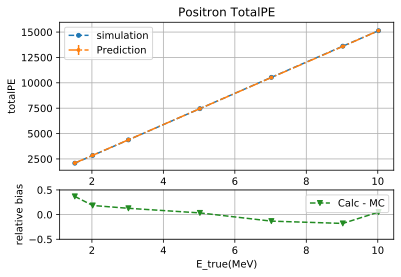

In [51]:

from pylab import *
from matplotlib import gridspec 
gs = gridspec.GridSpec(2,1,height_ratios=[3,1]) 


ax0 = plt.subplot(gs[0])
ax0.plot(E_positron, totalpe_positron, "o--", ms=4, label="simulation")
#ax0.plot(E_positron, totpe_positron_pred, "s--", ms=4, label="prediction")
ax0.errorbar(E_positron, totpe_positron_pred, yerr=totpe_sigma_positron, fmt="o-.", ms=3, label="Prediction")
#plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')


ax0.legend()
plt.grid(True)
plt.ylabel('totalPE')
plt.title('Positron TotalPE')

ax1 = plt.subplot(gs[1])
ax1.plot(E_positron, (np.array(totpe_positron_pred)-np.array(totalpe_positron))/np.array(totpe_sigma_positron), 
         'v--', ms=5,color='forestgreen', label="Calc - MC")

plt.grid(True)
#plt.yticks(np.arange(0, 1200, step=400))
plt.xlabel('E_true(MeV)')
plt.ylabel('relative bias')
plt.ylim(-0.5, 0.5)
plt.legend(loc='upper right')

#plt.savefig('compare_totalPE_electron.svg')

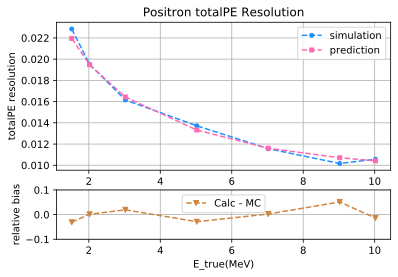

In [42]:

from pylab import *
from matplotlib import gridspec 
gs = gridspec.GridSpec(2,1,height_ratios=[3,1]) 


ax0 = plt.subplot(gs[0])
ax0.plot(E_positron, np.array(totpe_sigma_positron)/np.array(totalpe_positron), 
         "o--", ms=4, label="simulation", color='dodgerblue')
ax0.plot(E_positron, np.array(totpe_sigma_positron_pred)/np.array(totpe_positron_pred), 
         "s--", ms=4, label="prediction", color='hotpink')
#plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')


ax0.legend()
plt.grid(True)
plt.ylabel('totalPE resolution')
plt.title('Positron totalPE Resolution')

ax1 = plt.subplot(gs[1])
ax1.plot(E_positron, (np.array(totpe_sigma_positron_pred)-np.array(totpe_sigma_positron))/np.array(totpe_sigma_positron), 
         'v--', ms=5,color='peru', label="Calc - MC")

plt.grid(True)
#plt.yticks(np.arange(0, 1200, step=400))
plt.xlabel('E_true(MeV)')
plt.ylabel('relative bias')
plt.ylim(-0.1, 0.1)
plt.legend(loc='upper center')

plt.savefig('positron_resolution.svg')

## Compare NonLinearity with two methods

In [9]:
MC_totnonl_vis1MeV=[
0.9476542853111201,
0.9802862665305231,
1.0047294172184928,
1.0144847153300176,
1.0196907321142077]; MC_totnonl_vis1MeV = np.array(MC_totnonl_vis1MeV)

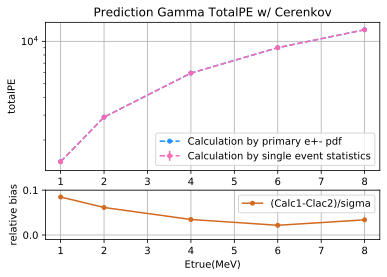

In [20]:
## Compare gamma nonl prediction in two methods:

## Old electron probability
# Draw totalPE comparison:
from pylab import *
from matplotlib import gridspec 
gs = gridspec.GridSpec(2,1,height_ratios=[3,1]) 

Edep = [1,2,4,6,8];
totalPE = [1393, 2890, 5936, 8998, 12060];
Edep_pred = [1,2,4,6,8]
totalPE_pred = [1400, 2899.63, 5948.8, 9012.35, 12076.87]
totalPE_sigma_pred = [41.73, 66.83, 100.16, 126.03, 145.27]; totalPE_sigma_pred = np.array(totalPE_sigma_pred)
scale = 1.; #MC_totnonl_vis1MeV[0]/(totalPE[0]/Edep[0]/A);
totalPE_nonl = []; totalPE_nonl_pred = []; MC_totalPE = [];
A = 1481.06
for i in range(5):
    totalPE_nonl.append(totalPE[i]/Edep[i]/A*scale)
    MC_totalPE.append(MC_totnonl_vis1MeV[i] * A * Edep[i])
for i in range(5):    
    totalPE_nonl_pred.append(totalPE_pred[i]/Edep_pred[i]/A*scale)


ax0 = plt.subplot(gs[0])
ax0.plot(Edep, MC_totalPE,'o--',label='Calculation by primary e+- pdf', ms=4, color='dodgerblue')
ax0.errorbar(Edep_pred, totalPE_pred, yerr = totalPE_sigma_pred,fmt='o--',
             label='Calculation by single event statistics', ms=4, color="hotpink")
#ax0.plot(Edep, totalPE_nonl, 's-.', label='Geant4.10.02', ms=4, color='hotpink')
ax0.legend()
#plt.text(1.9,0.025,"Scale to 1MeV", fontsize=13, color='darkviolet')
#plt.arrow(1.1,0.0276,0.65,-0.0015,color='darkviolet', width=0.0002,head_length=0.05)
plt.semilogy()
plt.grid(True)
plt.ylabel('totalPE')
plt.title("Prediction Gamma TotalPE w/ Cerenkov")

ax1 = plt.subplot(gs[1])
ax1.plot(Edep, (np.array(MC_totalPE)-np.array(totalPE_pred))/np.array(totalPE_sigma_pred), 
         'o-',ms=4, color='chocolate', label='(Calc1-Clac2)/sigma')


plt.grid(True)
#plt.yticks(np.arange(0, 1200, step=400))
plt.xlabel('Etrue(MeV)')
plt.ylabel('relative bias')
plt.ylim(-0.01,0.1)
plt.legend(loc='upper right')

#plt.savefig('compare_totalPE_electron.svg')